In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [9]:
# Display columns in each table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'],c['type'])

print("--------")    
    
columns2 = inspector.get_columns('station')
for c in columns2:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement.date).\
        order_by(Measurement.date.desc()).first()

print(f"The most recent date/last date in the data set is {most_recent.date}.")

The most recent date/last date in the data set is 2017-08-23.


For this data, we'll look at dates between 2016-08-23 and 2017-08-23.


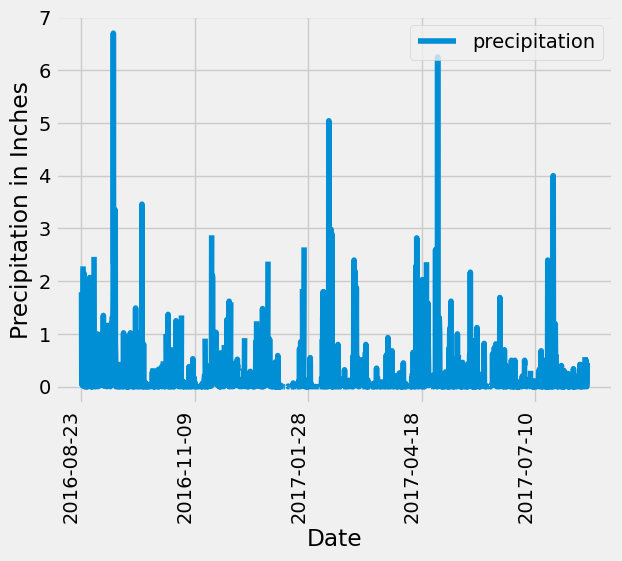

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

next_year = dt.datetime.strptime(most_recent.date, '%Y-%m-%d')
next_year = next_year + timedelta(days=-365)
next_year = datetime.strftime(next_year, '%Y-%m-%d')
print(f"For this data, we'll look at dates between {next_year} and {most_recent.date}.")

# Perform a query to retrieve the data and precipitation scores
       
annual_precip =  session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date >= '2016-08-23').all()


# Save the query results as a Pandas DataFrame and set the index to the date column
annual_precip_df = pd.DataFrame(annual_precip, columns=['date','precipitation'])
annual_precip_df.set_index('date', inplace=True)


# Sort the dataframe by date
annual_precip_df.sort_values(by='date', ascending=False)
annual_precip_df = annual_precip_df.sort_index()


# Use Pandas Plotting with Matplotlib to plot the data
annual_precip_df.plot.line()
plt.xticks(rotation=90, ha='right')
plt.legend(loc="upper right")
plt.xlabel("Date")
plt.ylabel("Precipitation in Inches")
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data

annual_precip_df[['precipitation']].describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
all_stations = session.query(Measurement.station).\
        group_by(Measurement.station).count()

print(f"There are a total of {all_stations} distinct stations in the data.")

There are a total of 9 distinct stations in the data.


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

sel = [Measurement.station, func.count(Measurement.prcp)]

all_readings = session.query(*sel).\
                group_by(Measurement.station).\
                order_by(sel[1].desc()).all()

all_readings


[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

sel = [Measurement.station,
      func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)]

active_station = session.query(*sel).\
                filter(Measurement.station=='USC00519281').all()

active_station_df = pd.DataFrame(active_station, columns=['station', 'min_temp', 'max_temp', 'avg_temp'])

active_station_df.head()

,station,min_temp,max_temp,avg_temp
0,USC00519281,54.0,85.0,71.663781


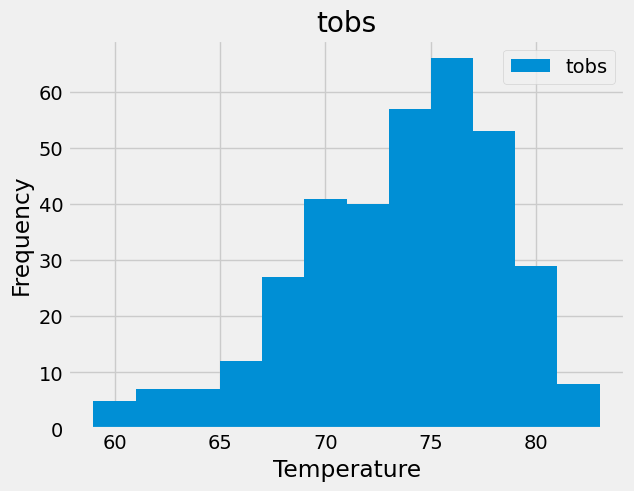

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_annual = session.query(Measurement.station, Measurement.tobs).\
                    filter(Measurement.station == 'USC00519281').\
                    filter(Measurement.date >= next_year).\
                    group_by(Measurement.date).\
                    order_by(Measurement.date).all()


active_station_df = pd.DataFrame(most_active_annual, columns=['station', 'tobs'])
active_station_df

active_station_df.hist(bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(['tobs'],loc="upper right")
plt.show()


# Close session

In [17]:
# Close Session
session.close()